# Failure-Time Data with no Explanatory Variables
---

In [333]:
%pip install pyreadr pandas matplotlib np lifelines

     |████████████████████████████████| 348 kB 5.2 MB/s eta 0:00:01
     |████████████████████████████████| 55 kB 2.1 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


# Table of Contents
1. Example 1: Integrated Circuit Life Test Data
2. Example 2: Circuit Pack Reliability Field Trial
3. Example 3: Diesel Generator Fan Failure Data
4. Example 4: Heat Exchanger Tube Crack Data
5. Example 5: Transmitter Vacuum Tube Data
6. Example 6: Turbine Wheel Crack Initiation Data

In [17]:
import pyreadr
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import itertools
import functools
import operator
import lifelines
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.plotting import plot_lifetimes
from statsmodels.distributions.empirical_distribution import ECDF

matplotlib.rcParams['figure.figsize'] = (20, 10)

# Example 1
## Integrated Circuit Life Test Data
---

<img src="assets/integrated_circuit.JPG" alt="Integrated Circuit" width="300"/>

Results of a life test $ n = 4156 $ integrated circuits tested for $ 1370 $ hours at accelerated conditions of $ 80^\circ C$ and $80\%$ relative humidity. The accelerated conditions were used to shorten the test by causing defective units to fail more rapidly. 


In [18]:
# Load dataset (Integrated Circuit Life Test Data [ICLTD])
ICLTD = pyreadr.read_r('./data/lfp1370.RData')['lfp1370']

ICLTD = ICLTD.loc[ICLTD.index.repeat(ICLTD['count'])]
del ICLTD['count']

# Preview data format
ICLTD.head(5)

,hours,event
0,0.10,Failure
0,0.10,Failure
1,0.15,Failure
2,0.60,Failure
3,0.80,Failure


As you can see, the dataset is a list of rows corresponding to how many hours the integrated circuit lasted. The "count" column indicated how many integrated circuits failed/suspended at that many hours of testing. Let's check the total number of circuit boards tested by summing up the "count" column. We can also calculate the total time on test by summing up the "hours" column.

Total qty tested: 4156
Time on test: 5656967.75

Statistics regarding failures only
            hours
count   28.000000
mean    57.419643
std    120.271020
min      0.100000
25%      2.175000
50%     11.250000
75%     49.500000
max    593.000000



<AxesSubplot:title={'center':'Integrated Circuit Failure Times'}>

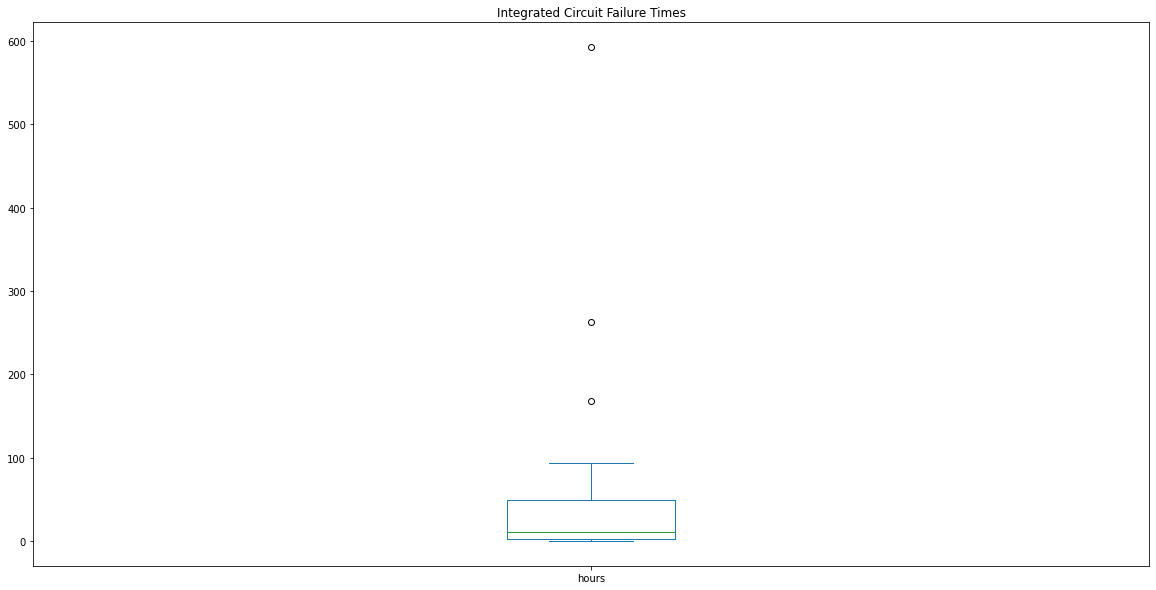

In [19]:
print(f'Total qty tested: {len(ICLTD)}')
print(f'Time on test: {ICLTD["hours"].sum()}\n')

# The describe() method returns some useful statistics about the dataset
print("Statistics regarding failures only")
print(ICLTD[ICLTD['event'] == 'Failure'].describe())
print()

ICLTD[ICLTD['event'] == 'Failure'].hours.plot(kind='box', x='hours', title='Integrated Circuit Failure Times')

The above boxplot excludes integrated circuits which were suspended (as opposed to failed). Some information about the suspended data is below. We can see that all censored data occurs at the same time 1370 hours.

In [20]:
ICLTD[ICLTD['event'] == 'Censored'].describe()

,hours
count,4128.0
mean,1370.0
std,0.0
min,1370.0
25%,1370.0
50%,1370.0
75%,1370.0
max,1370.0


We will now more closely examine the number of failures within the first $100$ hours. Notice that there are 25 failures within this time, with the mean failure time being $23$ hours.

           hours
count  25.000000
mean   23.350000
std    29.012971
min     0.100000
25%     1.200000
50%    10.000000
75%    43.000000
max    94.000000


<AxesSubplot:title={'center':'Integrated Circuit Failure Times'}>

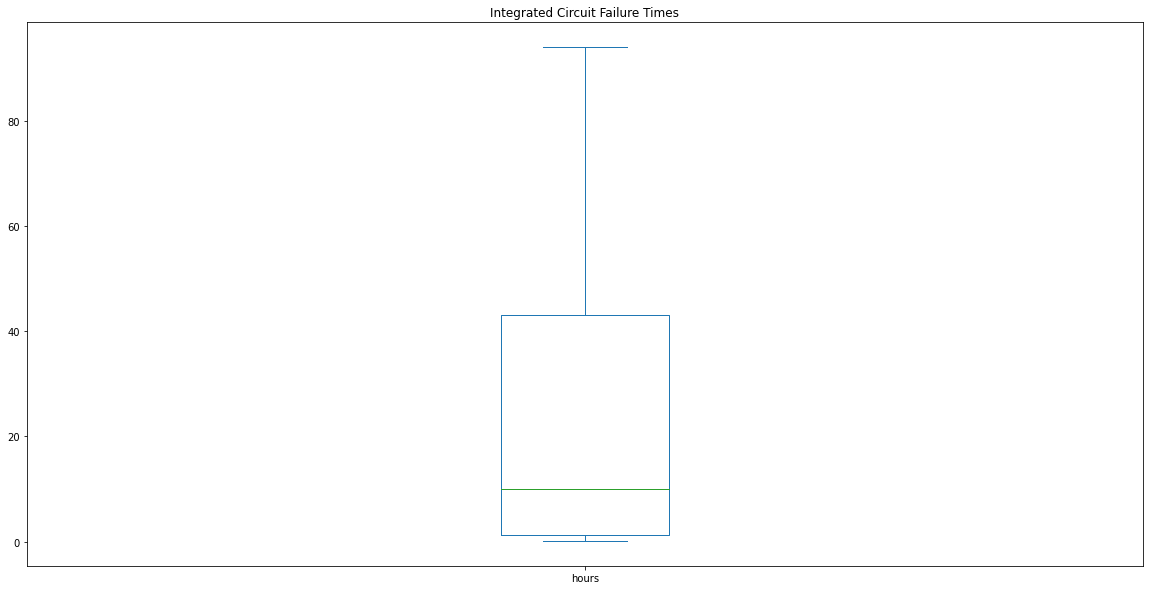

In [21]:
print(ICLTD[(ICLTD['event'] == 'Failure') & (ICLTD['hours'] < 100)].describe())
ICLTD[(ICLTD['event'] == 'Failure') & (ICLTD['hours'] < 100)].hours.plot(kind='box', x='hours', title='Integrated Circuit Failure Times')

# Example 2
## Circuit Pack Reliability Field Trial
---

<img src="assets/circuit_pack.jpg" alt="Circuit Pack" width="300"/>
Periodic inspections were conducted in a field trial of early-production circuit packs employing new technology devices.
The circuit packs were manufactured under the same design, but by two different vendors. The trial ran for 10000 hours. The 4993 circuit packs from Vendor 1 came straight from production. 4993 circuit packs from Vendor 2 had already seen 1000 hours of burn-in testing at the maufacturing plant under operating condition similar to those in the field trial. Such circuit packs were sold at a higher price because field reliability was supposed to have been improved by the burn-in screening of circuit packs containing defective components. Failures during the first 1000 hours of burn-in were not recorded. This is the reason for the unknown entries in the table and for having information out to 11000 hours for Vendor 2.
Inspections were costly and were spaced more closely at the beginning of the study because more failures were expected there. 
#### Goals of the study
- Determine if there was an important difference in te reliability ofthe products from the two different vendors.
- Determine the specific causes of failures so that the information could be used to improve product design or manufacturing methods.
- Estimate the circuit pack "hazard function" out to 10000 hours
- Estimate the point at which the hazard function levels off. After this point in time, burn-in would not be useful for improving the reliability of the circuit packs
- Judge if and when the burn-in period can be used effectively to improve early-life reliability
- Estimate the failure-time distribution for the first 10000 hours of life (the warranty period for the product)
- Estimate the proportion of units that will fail in the first 50000 hours of life.



In [22]:
# Load dataset (Circuit Pack Reliability Field Trial [CPRFT])
CPRFT = pyreadr.read_r('./data/cirpack6.RData')['cirpack6']
CPRFT = CPRFT.loc[CPRFT.index.repeat(CPRFT['count'])]
del CPRFT['count']
CPRFT

,hoursl,hoursu,event,trunccode,trunctime,vendor
0,1,1,Left,1,0,V1
0,1,1,Left,1,0,V1
0,1,1,Left,1,0,V1
0,1,1,Left,1,0,V1
0,1,1,Left,1,0,V1
...,...,...,...,...,...,...
26,11000,11000,Suspended,3,1000,V2
26,11000,11000,Suspended,3,1000,V2
26,11000,11000,Suspended,3,1000,V2
26,11000,11000,Suspended,3,1000,V2


Here we can see the structure of the data.
`hoursl` and `hoursu` specify the interval of time where the event happened. This is an interval and not a specific value because in practice the people conducting the experiment couldn't know the exact moment a circuit pack would break. They would conduct inspections of all the packs periodically, they would then know if a circuit pack broke since their last inspection (but they don't know exactly when during that time). `event` tells us the kind of event this is, it can take on 3 categories: `Left`, `Interval` and `Suspended`. "Left" corresponds to the packs which were removed during Vendor 1's burn-in phase, "Suspended" corresponds to packs that remained running at the end of the experiment, "Interval" corresponds to packs which failed during an interval of time \[hoursl, hoursu\]. `vendor` states which vendor manufactured the circuit pack.

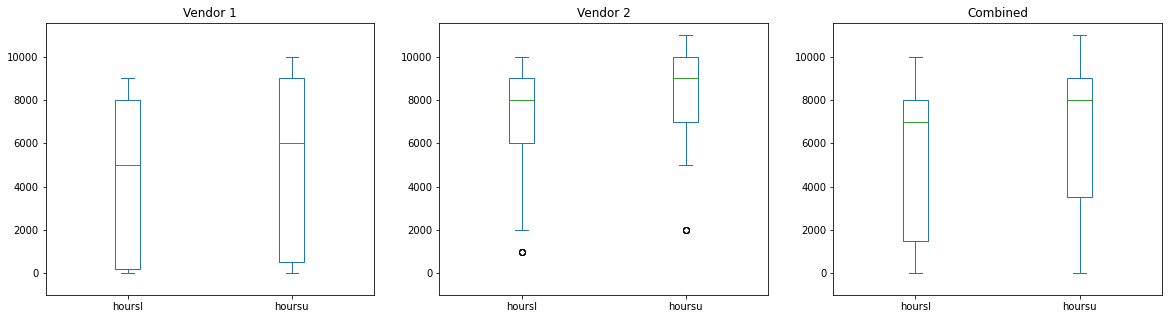

In [23]:
failures = CPRFT[(CPRFT['event'] == 'Interval')]

fig, ax = plt.subplots(1,3, figsize=(20,5))

ymin, ymax = min(min(failures.hoursl), min(failures.hoursu)), max(max(failures.hoursl), max(failures.hoursu))

failures[failures.vendor == 'V1'][['hoursl', 'hoursu']].plot(kind="box", title='Vendor 1', ax = ax[0])
failures[failures.vendor == 'V2'][['hoursl', 'hoursu']].plot(kind="box", title='Vendor 2', ax = ax[1])
failures[['hoursl', 'hoursu']].plot(kind="box", title='Combined', ax = ax[2])
for i in range(3):
    # make all subplots have the same axis ranges
    ax[i].set_ylim(ymin - 1000, ymax * 1.05)
    
plt.show(fig)

These $ 3 $ boxplots show the the failure times of the circuit packs for each vendor (**I have only included datapoints which are interval censored**). Each plot consists of 2 sub-plots, one for the fields corresponding to the lower bound on the interval and one for the upper bounds. 
Take a look at the data we loaded, you may suggest a reasonable estimate for the time a failure happened during an interval is in-between the lower and upper bound, this is false (this phenomenon is named the Poisson Paradox or Inspection Paradox) however is out of the scope of this analysis. 

Text(0.5, 1.0, 'Vendor 2 Survival Function')

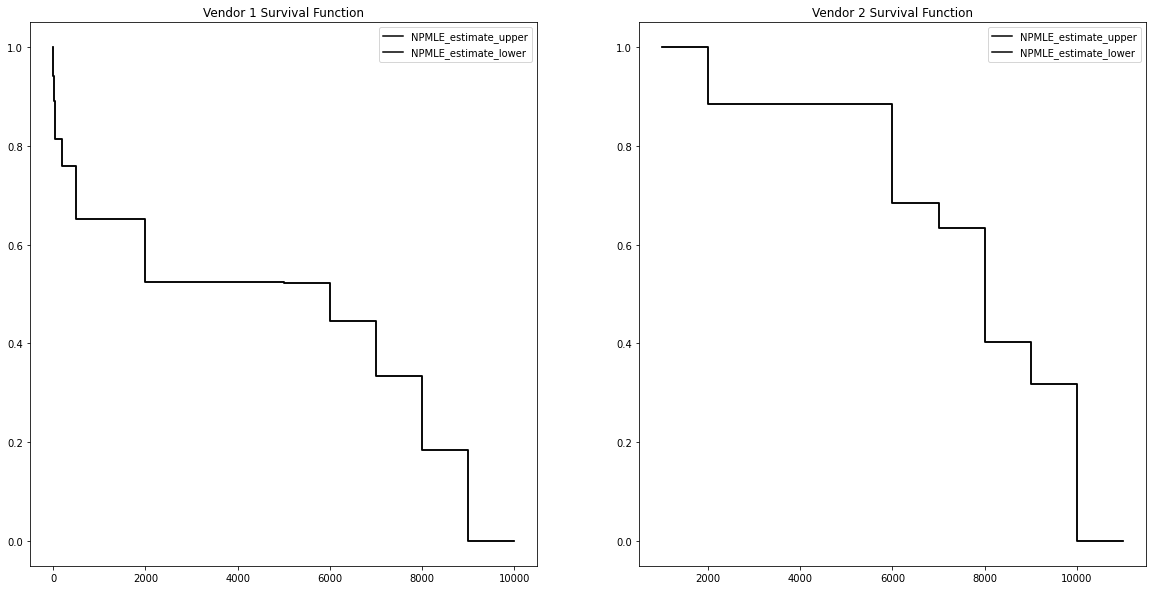

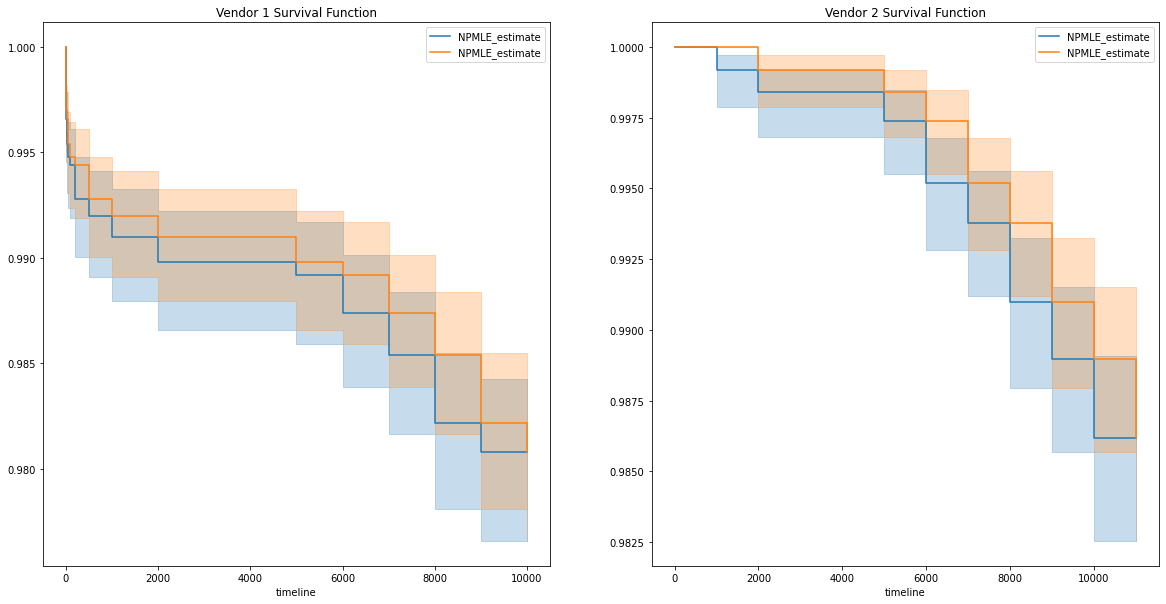

In [30]:
v1 = CPRFT[(CPRFT.vendor == 'V1')]
v2 = CPRFT[(CPRFT.vendor == 'V2')]

v1_intervals_only = v1[v1.event == 'Interval']
v2_intervals_only = v2[v2.event == 'Interval']

from lifelines.plotting import plot_interval_censored_lifetimes

fig, ax = plt.subplots(1, 2)

kmf = KaplanMeierFitter()
kmf.fit_interval_censoring(v1_intervals_only.hoursl, v1_intervals_only.hoursu)
kmf.plot(ax=ax[0])
ax[0].set_title('Vendor 1 Survival Function')

kmf.fit_interval_censoring(v2_intervals_only.hoursl, v2_intervals_only.hoursu)
kmf.plot(ax=ax[1])
ax[1].set_title('Vendor 2 Survival Function')

fig, ax2 = plt.subplots(1, 2)

kmf.fit(v1.hoursl, v1.event != 'Suspended')
kmf.plot(ax=ax2[0])

kmf.fit(v1.hoursu, v1.event != 'Suspended')
kmf.plot(ax=ax2[0])

kmf.fit(v2.hoursl, v2.event != 'Suspended')
kmf.plot(ax=ax2[1])

kmf.fit(v2.hoursu, v2.event != 'Suspended')
kmf.plot(ax=ax2[1])

ax2[0].set_title('Vendor 1 Survival Function')
ax2[1].set_title('Vendor 2 Survival Function')

The above emperical estimates of the *survival function* have been generated using the **Kaplan Meier Estimate**. The top two plots incorporate the fact that the data is interval censored but ignore the left censoring and right censoring. The bottom two plots incorporate the right censoring but ignore the left censoring and the interval censoring. The inability to incorporate multiple types of censored data is a limitation of the python package used in this analysis.

Text(0.5, 1.0, 'Vendor 2 Hazard Function')

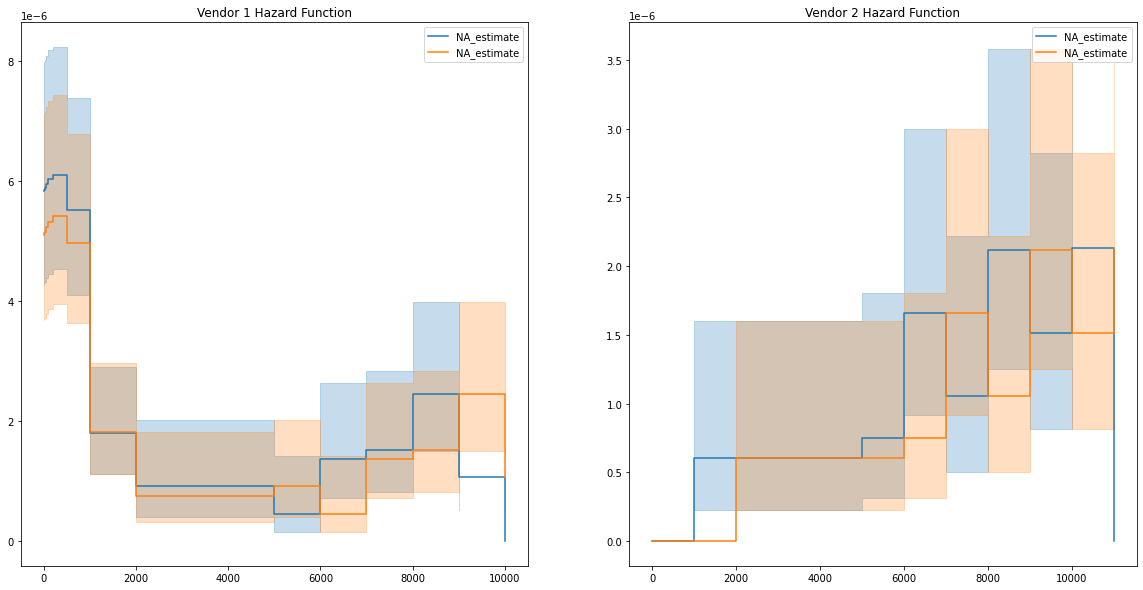

In [31]:
naf = NelsonAalenFitter()
bandwidth = 1000.

fig, ax = plt.subplots(1, 2)

naf.fit(v1.hoursl, v1.event != 'Suspended')
naf.plot_hazard(ax=ax[0], bandwidth = bandwidth)

naf.fit(v2.hoursl, v2.event != 'Suspended')
naf.plot_hazard(ax=ax[1], bandwidth = bandwidth)

naf.fit(v1.hoursu, v1.event != 'Suspended')
naf.plot_hazard(ax=ax[0], bandwidth = bandwidth)

naf.fit(v2.hoursu, v2.event != 'Suspended')
naf.plot_hazard(ax=ax[1], bandwidth = bandwidth)

ax[0].set_title('Vendor 1 Hazard Function')
ax[1].set_title('Vendor 2 Hazard Function')

The above emperical estimates of the *hazard function* have been generated using the **Nelson Aalen Estimate**. The estimates correctly incorporate the right censoring but ignore the left censoring and the interval censoring. The inability to incorporate multiple types of censored data is a limitation of the python package used in this analysis.

# Example 3
## Diesel Generator Fan Failure Data
---

<img src="assets/deisel_generator.jpg" alt="Deisel Generator" width="300"/>

Failures in 12 of 70 generator fans were reported at times ranging between 450 hours and 8750 hours. Of the 58 units that did not fail, the reported running times (i.e., censoring times) ranged between 460 and 11500 hours. Different fans had dfifferent running times because units were introduced into service at different times and because their use-rates differed. 
Diesel Generator Fan Failure
### Goals of the study
- What percentage of the units will fail under warranty?
- Would the fan failure problem get better or worse in the future? In reliability terminology, does hazard function (sometimes called failure rate) for fans increase or decrease with fan age?


In [32]:
# Load dataset (Diesel Generator Fan Failure Data [DGFFD])
DGFFD = pyreadr.read_r('./data/fan.rda')['fan']

DGFFD = DGFFD.loc[DGFFD.index.repeat(DGFFD['count'])]
del DGFFD['count']

DGFFD.reset_index(drop=True, inplace=True)

# Preview data format
DGFFD.head(5)

,hours,event
0,450.0,Fail
1,460.0,Censored
2,1150.0,Fail
3,1150.0,Fail
4,1560.0,Censored


In [33]:
DGFFD.describe()

,hours
count,70.000000
mean,4920.571429
std,2837.406902
min,450.000000
25%,2110.000000
50%,4300.000000
75%,7262.500000
max,11500.000000


The data has a very basic structure, each measured event has a time and then the kind of event. For example, the first fan failed at 450 hours whereas the second fan was suspeded at 460 hours.

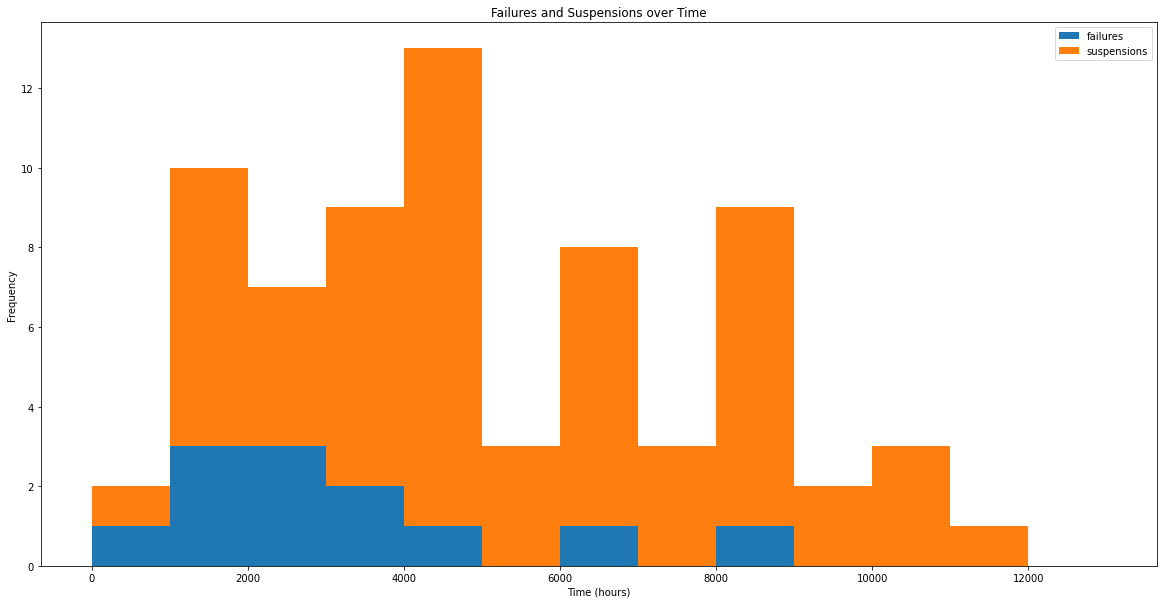

In [34]:
suspensions = DGFFD[DGFFD.event == 'Censored'].hours
failures = DGFFD[DGFFD.event == 'Fail'].hours

suspensions.name = 'suspensions'
failures.name = 'failures'

pd.DataFrame([failures, suspensions]).T.plot.hist(histtype='bar', stacked=True, bins=np.arange(0, 14000, 1000), title='Failures and Suspensions over Time')
plt.xlabel('Time (hours)')
plt.show()

This plot shows a stacked histogram for failures and suspensions over time. We have a lot of data with a "low" number of hours: both failures and suspensions. An initial glance at this plot may make you believe that failures occur earlier in the lifetime of the deisel generator fans (indicating the existence of "burn-in" failures) however, also notice that there are more suspensions at earlier times than later times too, which indicates there are lots of deisel generator fans surviving at the start of the test. We will have to perform more analysis to form a conclusion.

Text(0.5, 1.0, 'Deisel Generator Fan Failures of our population')

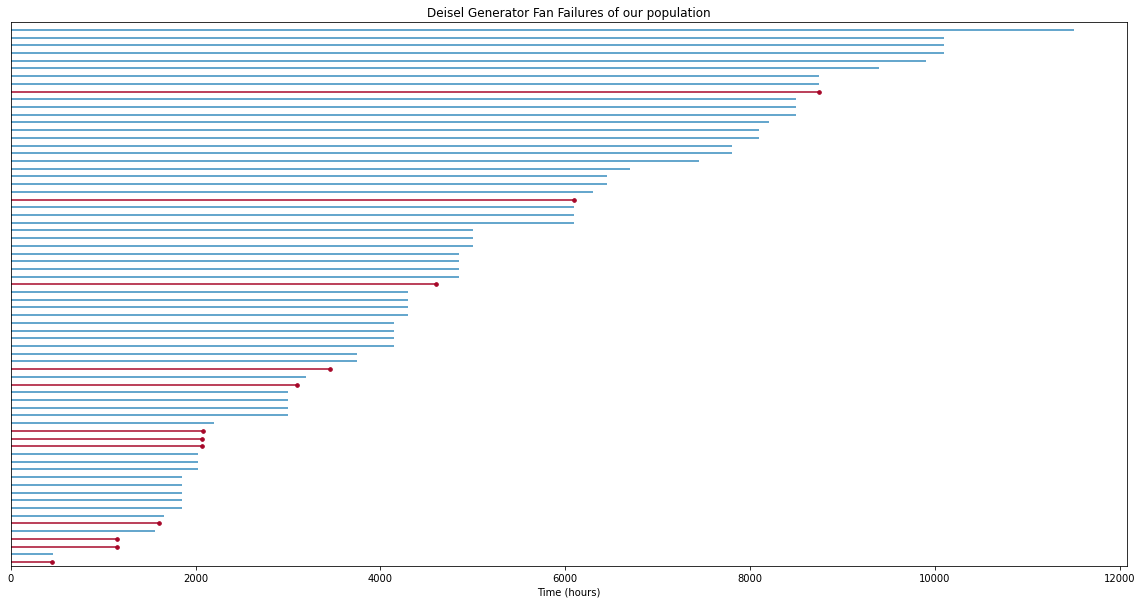

In [37]:
DGFFD_subsample = DGFFD.loc[np.random.permutation(DGFFD.index)]

ax = plot_lifetimes(DGFFD_subsample.hours, DGFFD_subsample.event == 'Fail')

ax.set_xlabel("Time (hours)")
ax.set_yticks([])
ax.set_title("Deisel Generator Fan Failures of our population")

Another classic visualisation of censored failure data. Red bars represent failures with a known failure time. Blue bars represent suspensions with an unknown failure time.

# Example 4
## Heat Exchanger Tube Crack Data

<img src="assets/heat_exchanger.jpg" alt="Heat Exchanger Tubes" width="300"/>

Nuclear power plants use heat exchangers to transfer energy from the reactor to steam turbines. A typical heat exchanger contains thousands of tubes through which steam flows continuously when the heat exchanger is in service. With age, heat exchanger tubes develop cracks, usually due to some combination of stress-corrosion and fatigue. A heat exchanger can continue to operate safely when the cracks are small. If cracks get large enough, however, leaks can develop, and these could lead to serious safety problems and expensive, unplanned plant shut-down time. To protect against least, heat exchangers are taken out of serviec periodically so that its tubes (and other components) can be inspected with nondestructive evaluation techniques. At the end of each inspection period, tubes with detected cracks are plugged so that water will no longer pass through them. This reduces plant efficiency but extends the life of the expensive heat exchangers. With this in mid, heat exchangers are built with extra capacity and can remmain in operation up until the point where a certain percentage (e.g., 5%) of the tubes have been plugged.  

In [73]:
# Load dataset (Diesel Generator Fan Failure Data [DGFFD])
HETCD = pyreadr.read_r('./data/heatexchanger.rda')['heatexchanger']
HETCD = HETCD.loc[HETCD.index.repeat(HETCD['count'])]
del HETCD['count']

HETCD.reset_index(drop=True, inplace=True)

# Preview data format
HETCD.head(5)

,lower,upper,event,plant
0,1,1,Left,Plant1
1,1,2,Interval,Plant1
2,1,2,Interval,Plant1
3,2,3,Interval,Plant1
4,2,3,Interval,Plant1


In [79]:
HETCD.loc[HETCD.event == 'Right', 'upper'] = np.Infinity
HETCD.loc[HETCD.event == 'Left', 'lower'] = 0

<AxesSubplot:>

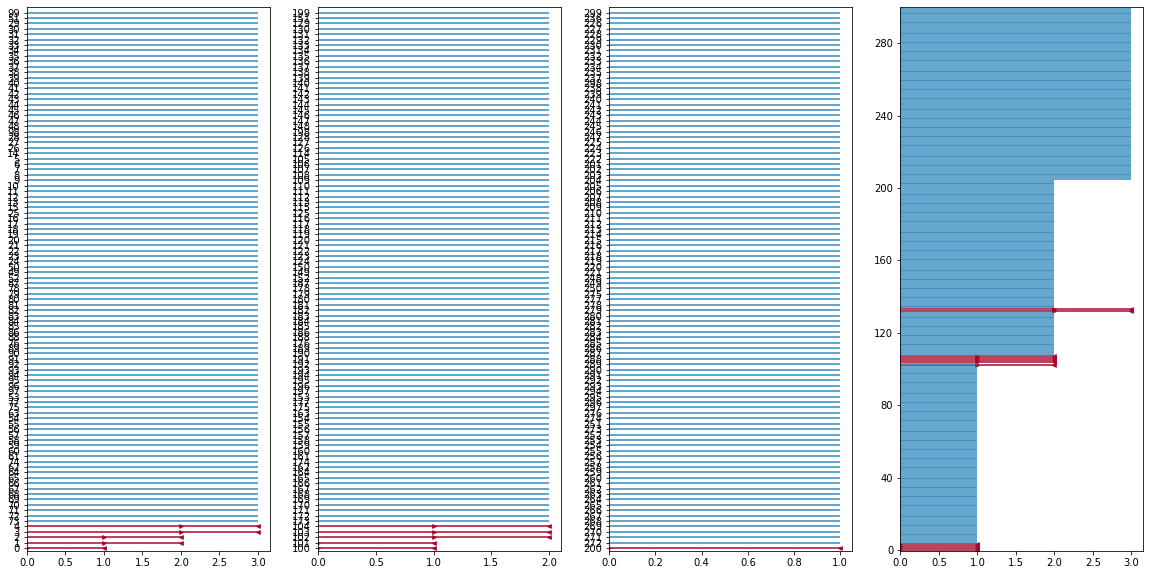

In [83]:
fig, ax = plt.subplots(1, 4)
HETCD_p1 = HETCD[HETCD.plant == 'Plant1']
HETCD_p2 = HETCD[HETCD.plant == 'Plant2']
HETCD_p3 = HETCD[HETCD.plant == 'Plant3']

plot_interval_censored_lifetimes(lower_bound=HETCD_p1['lower'], upper_bound=HETCD_p1['upper'], ax = ax[0])
plot_interval_censored_lifetimes(lower_bound=HETCD_p2['lower'], upper_bound=HETCD_p2['upper'], ax = ax[1])
plot_interval_censored_lifetimes(lower_bound=HETCD_p3['lower'], upper_bound=HETCD_p3['upper'], ax = ax[2])
plot_interval_censored_lifetimes(lower_bound=HETCD['lower'], upper_bound=HETCD['upper'], ax = ax[3])

# Example 5
## Transmitter Vacuum Tube Data

<img src="assets/vacuum_tube.jpg" alt="Vacuume Tube" width="300"/>

# Example 6
## Turbine Wheel Crack Initiation Data

<img src="assets/turbine_wheel.jpg" alt="Turbine Wheel" width="300"/>